In [ ]:
# # Note: This section is intended for use in Google Colab only.

# import os
# import shutil

# # Define the repository URLs and set the home directories based on Colab's file structure
# repo = {"url": "https://github.com/noye09/cs612_SMU_g4.git", "target_dir": "/content/cs612_SMU_g4"}


# # Clone the repositories if they don't exist
# if not os.path.isdir(repo["target_dir"]):
#     print(f"Cloning repository from {repo['url']}...")
#     !git clone {repo['url']}

#     # Rename folder if needed (e.g., replacing hyphens with underscores)
#     if repo["url"].endswith("badnets-pytorch.git"):
#         shutil.move("badnets-pytorch", repo["target_dir"])
# else:
#     print(f"Repository already cloned at {repo['target_dir']}!")

# # Set the working directory to the desired location
# HOME_DIR = "/content/cs612_SMU_g4/backdoor_cs612/"
# if os.path.isdir(HOME_DIR):
#     os.chdir(HOME_DIR)
#     print(f"Changed working directory to: {os.getcwd()}")
# else:
#     print(f"Directory '{HOME_DIR}' does not exist.")


In [1]:
# TriggerOptimizer
# 'initialize_model_and_data' initializes and loads the backdoor model
# 'detect_backdoor' runs the backdoor detection process

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
import warnings

#import matplotlib.pyplot as plt  # For debugging and visualization

from model_class.model_mnist import MNISTNet  # Import MNIST model class from model_mnist.py
from model_class.model_cifar10 import CIFAR10Net  # Import CIFAR-10 model class from model_cifar10.py
from model_class.badnet import BadNet

warnings.filterwarnings("ignore")  # Suppress warnings


class TriggerOptimizer:
    def __init__(self, model, target_class, dataset, input_shape, device='cpu', lr=0.0005):
        # Initialize model, parameters, and optimizer settings
        self.model = model
        self.target_class = target_class
        self.dataset = dataset
        self.input_shape = input_shape
        self.device = device
        self.lr = lr

        # Initialize mask and pattern
        self.mask = torch.rand(input_shape, requires_grad=True, device=device)
        self.pattern = torch.rand(input_shape, requires_grad=True, device=device)
        self.optimizer = optim.Adam([self.mask, self.pattern], lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1500, gamma=0.5)  # Adjusted schedule

    def optimize(self, max_iters=5000, patience=300, batch_size=10):
        """
        Generate a minimal trigger mask and pattern for the specified target class.
        """
        # Shuffle dataset to ensure diversity
        dataset_indices = torch.randperm(len(self.dataset))

        # Find multiple images belonging to the target class
        samples = []
        for idx in dataset_indices:
            img, lbl = self.dataset[idx]
            if lbl == self.target_class:
                samples.append(img)
            if len(samples) >= batch_size:
                break

        if len(samples) == 0:
            raise ValueError(f"No samples found for target class {self.target_class}")

        sample_inputs = torch.stack(samples).to(self.device)

        best_loss = float('inf')
        counter = 0

        for i in range(max_iters):
            self.optimizer.zero_grad()

            # Apply mask and pattern on each sample input in the batch
            masked_inputs = self.pattern * self.mask + sample_inputs * (1 - self.mask)

            # Forward pass
            outputs = self.model(masked_inputs)  # Get predictions for all samples

            # Calculate the loss (encourage model to predict the target class)
            target_labels = torch.full((batch_size,), self.target_class, dtype=torch.long, device=self.device)
            target_loss = nn.CrossEntropyLoss()(outputs, target_labels)

            # Regularization to minimize the mask area (encourage sparse mask)
            mask_penalty = self.mask.abs().mean()
            total_loss = target_loss + 0.001 * mask_penalty

            # Backpropagation
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            # Clip mask to keep values between 0 and 1
            self.mask.data = torch.clamp(self.mask.data, 0, 1)

            # Early stopping condition
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at iteration {i} due to no improvement")
                    break

            # Print progress every 500 iterations
            if i % 500 == 0:
                print(f"Iteration {i}/{max_iters}, Loss: {total_loss.item()}")

        return self.mask.detach(), self.pattern.detach()


def initialize_model_and_data(model_selection, model_path, device='cpu'):
    """
    Initializes the model and loads data based on the model selection.
    """
    DATASET_OPTIONS = {
    'mnist': {
        'model_class': MNISTNet,
        'dataset_class': datasets.MNIST,
        'model_kwargs': {}
    },
    'cifar10': {
        'model_class': CIFAR10Net,
        'dataset_class': datasets.CIFAR10,
        'model_kwargs': {}
    },
    'badnets_pytorch_mnist': {
        'model_class': BadNet,
        'dataset_class': datasets.MNIST,
        'model_kwargs': {'input_channels': 1, 'output_num': 10}
    },
    'badnets_pytorch_cifar10': {
        'model_class': BadNet,
        'dataset_class': datasets.CIFAR10,
        'model_kwargs': {'input_channels': 3, 'output_num': 10}
    }
}

    # Initialize the model and load data based on the model selection
    if model_selection not in DATASET_OPTIONS:
        raise ValueError(f"Invalid model selection '{model_selection}'. Available options: {list(DATASET_OPTIONS.keys())}")

    model_class = DATASET_OPTIONS[model_selection]['model_class']
    dataset_class = DATASET_OPTIONS[model_selection]['dataset_class']
    model_kwargs = DATASET_OPTIONS[model_selection]['model_kwargs']

    # Initialize model with possible arguments
    model = model_class(**model_kwargs)
    test_dataset = dataset_class(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # Load the model weights
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at path: {model_path}")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)  # Send model to specified device
    model.eval()  # Set model to evaluation mode

    return model, test_dataset



def detect_backdoor(model, dataset, num_classes, device='cpu'):
    """
    Detects potential backdoors in the model using Neural Cleanse.
    """
    model.to(device)
    input_shape = dataset[0][0].shape  # Get the shape of a single input image

    results = {
        "backdoor_detected": False,
        "anomaly_scores": {},
        "triggers": {}
    }

    mask_sizes = []

    for target_class in range(num_classes):
        try:
            # Generate a trigger for each class
            optimizer = TriggerOptimizer(model, target_class, dataset, input_shape, device=device)
            mask, pattern = optimizer.optimize(max_iters=3000)

            # Calculate the size of the mask (used to detect anomalies)
            mask_size = mask.abs().mean().item()
            mask_sizes.append(mask_size)

            # Store the mask and pattern for potential backdoor classes
            results["triggers"][target_class] = {
                "mask": mask.cpu().numpy(),
                "pattern": pattern.cpu().numpy(),
                "mask_size": mask_size
            }

        except Exception as e:
            # Handle cases where mask generation fails
            print(f"Error processing target class {target_class}: {e}")
            mask_sizes.append(np.nan)
            results["triggers"][target_class] = {
                "mask": None,
                "pattern": None,
                "mask_size": np.nan
            }

    # Calculate anomaly scores for each class
    valid_mask_sizes = [x for x in mask_sizes if not np.isnan(x)]
    mean_size = np.mean(valid_mask_sizes)
    std_size = np.std(valid_mask_sizes)

    for target_class, mask_size in enumerate(mask_sizes):
        if not np.isnan(mask_size):
            anomaly_score = (mask_size - mean_size) / (std_size + 1e-6)  # Avoid division by zero
            results["anomaly_scores"][target_class] = anomaly_score

            # If the anomaly score is below a certain threshold, flag it as a backdoor
            if anomaly_score < -2:  # Typically, a threshold like -2 or -3 standard deviations
                results["backdoor_detected"] = True
                results["target_class"] = target_class
        else:
            results["anomaly_scores"][target_class] = float('inf')
    #visualize_generated_masks(results)
    return results

# def visualize_generated_masks(results):
#     """
#     Visualizes the generated masks and patterns for each target class.
#     """
#     for target_class, trigger_info in results["triggers"].items():
#         if trigger_info["mask"] is None:
#             continue

#         mask = trigger_info["mask"]
#         pattern = trigger_info["pattern"]

#         # Plot the mask and pattern
#         plt.figure(figsize=(10, 5))

#         # Plot the mask
#         plt.subplot(1, 2, 1)
#         if len(mask.shape) == 3:  # If the mask has 3 dimensions
#             mask = mask[0]  # Take the first channel (assuming it's the same across channels)
#         plt.imshow(mask, cmap='gray')
#         plt.title(f"Mask for Target Class {target_class}")
#         plt.axis('off')

#         # Plot the pattern
#         plt.subplot(1, 2, 2)
#         if pattern.shape[0] == 3:  # RGB Image, shape is (C, H, W), need to convert to (H, W, C)
#             pattern = np.transpose(pattern, (1, 2, 0))  # Transpose from (C, H, W) to (H, W, C)
#             plt.imshow(pattern)
#         else:  # Grayscale
#             plt.imshow(pattern.squeeze(), cmap='gray')
#         plt.title(f"Pattern for Target Class {target_class}")
#         plt.axis('off')

#         plt.show()

In [ ]:
# Execute the main code block for model backdoor detection
# 'number_of_runs' is used to run the detection process multiple times to ensure consistency
# Outputs 'anomaly_scores' and 'detection_class' for X runs, saved as CSV files for further analysis

if __name__ == "__main__":

    # Define the available options for model_selection and model_path
    MODEL_SELECTION_OPTIONS = {
    1: {'model_selection': 'mnist', 'model_path': "./model1/mnist_bd.pt"},      # unknown backdoor model
    2: {'model_selection': 'cifar10', 'model_path': "./model2/cifar10_bd.pt"},  # unknown backdoor model
    3: {'model_selection': 'cifar10', 'model_path': "./model3/cifar10_bd.pt"},  # unknown backdoor model
    4: {'model_selection': 'cifar10', 'model_path': "./model4/cifar10_bd.pt"},  # unknown backdoor model
    5: {'model_selection': 'cifar10', 'model_path': "./model5/cifar10_bd.pt"},  # unknown backdoor model
    6: {'model_selection': 'badnets_pytorch_mnist', 'model_path': "./model6/badnet_MNIST.pth"},     # badnets-pytorch backdoor model target class label 1 
    7: {'model_selection': 'badnets_pytorch_cifar10', 'model_path': "./model7/badnet_CIFAR10.pth"}  # badnets-pytorch backdoor model target class label 1
    }

    selected_model_options = 7

    if selected_model_options in MODEL_SELECTION_OPTIONS:
        model_selection = MODEL_SELECTION_OPTIONS[selected_model_options]['model_selection']
        model_path = MODEL_SELECTION_OPTIONS[selected_model_options]['model_path']
        print(f"Selected: Model Selection = '{model_selection}', Model Path = '{model_path}'")

    # Set the device to GPU if available, otherwise use CPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Active device: {device}')

    # Define the number of runs for detection due to randomness
    number_of_runs = 10  # Run detection process multiple times for consistency

    # DataFrame to store results of multiple runs
    results_list = []

    # Run the backdoor detection multiple times and collect results
    for run in range(number_of_runs):
        print(f"Run {run + 1}/{number_of_runs}")

        # Initialize the model and dataset
        model, dataset = initialize_model_and_data(model_selection, model_path, device=device)
        num_classes = 10  # Number of classes (update if different)

        # Detect backdoor in the model
        results = detect_backdoor(model, dataset, num_classes, device=device)
        anomaly_scores = results["anomaly_scores"]
        detection_class = results.get("target_class", None) if results["backdoor_detected"] else None

        # Save results to list
        results_list.append({
            'run': run + 1,
            'class_0': anomaly_scores.get(0, None),
            'class_1': anomaly_scores.get(1, None),
            'class_2': anomaly_scores.get(2, None),
            'class_3': anomaly_scores.get(3, None),
            'class_4': anomaly_scores.get(4, None),
            'class_5': anomaly_scores.get(5, None),
            'class_6': anomaly_scores.get(6, None),
            'class_7': anomaly_scores.get(7, None),
            'class_8': anomaly_scores.get(8, None),
            'class_9': anomaly_scores.get(9, None),
            'target_class': detection_class
        })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results_list)

    # Extract filename components to construct CSV filename
    parent_folder = os.path.basename(os.path.dirname(model_path))
    os.makedirs('./output', exist_ok=True)
    csv_filename = os.path.join('./output', f"{parent_folder}_output.csv")
    
    # Save DataFrame to CSV file
    results_df.to_csv(csv_filename, index=False)
    print(f"Results saved to {csv_filename}")


Selected: Model Selection = 'mnist', Model Path = './model7/mnist_bd_50_c5.pt'
Active device: cuda
Run 1/10
Iteration 0/3000, Loss: 2.2853918075561523
Iteration 500/3000, Loss: 0.004779326729476452
Iteration 1000/3000, Loss: 0.00201999768614769
Iteration 1500/3000, Loss: 0.0012823848519474268
Iteration 2000/3000, Loss: 0.001100517576560378
Iteration 2500/3000, Loss: 0.0009644479723647237
Iteration 0/3000, Loss: 8.958544731140137
Iteration 500/3000, Loss: 0.03188387677073479
Iteration 1000/3000, Loss: 0.010586570017039776
Iteration 1500/3000, Loss: 0.006145291030406952
Iteration 2000/3000, Loss: 0.00504390150308609
Iteration 2500/3000, Loss: 0.003975762985646725
Iteration 0/3000, Loss: 2.998663902282715
Iteration 500/3000, Loss: 0.02379404567182064
Iteration 1000/3000, Loss: 0.006359452847391367
Iteration 1500/3000, Loss: 0.003154417034238577
Iteration 2000/3000, Loss: 0.002427831059321761
Iteration 2500/3000, Loss: 0.0019084373489022255
Iteration 0/3000, Loss: 1.4867579936981201
Iterat

In [78]:
import os
import pandas as pd
import glob

# Specify the folder path and the pattern to match
pattern = os.path.join("./output", "*_output.csv")
csv_files = glob.glob(pattern)

# Reload files with model identifiers
dfs_with_model = []

# Extract model names from file paths and add a 'model' column to each DataFrame
for file_path in csv_files:
    # Extract the model name from the filename by removing the folder path and the "_output.csv"
    base_name = os.path.basename(file_path)  # Get only the filename
    model_name = base_name.replace('_output.csv', '')  # Remove the suffix

    # Load the file and add the model identifier column
    df = pd.read_csv(file_path)
    df['target_class'] = df['target_class'].astype('Int64')
    df['model'] = model_name  # Add model identifier column
    dfs_with_model.append(df)

# Concatenate dataframes with model identifiers
df_merge = pd.concat(dfs_with_model, ignore_index=True)


# Save DataFrame to CSV file
df_merge.to_csv("df_merge.csv", index=False)


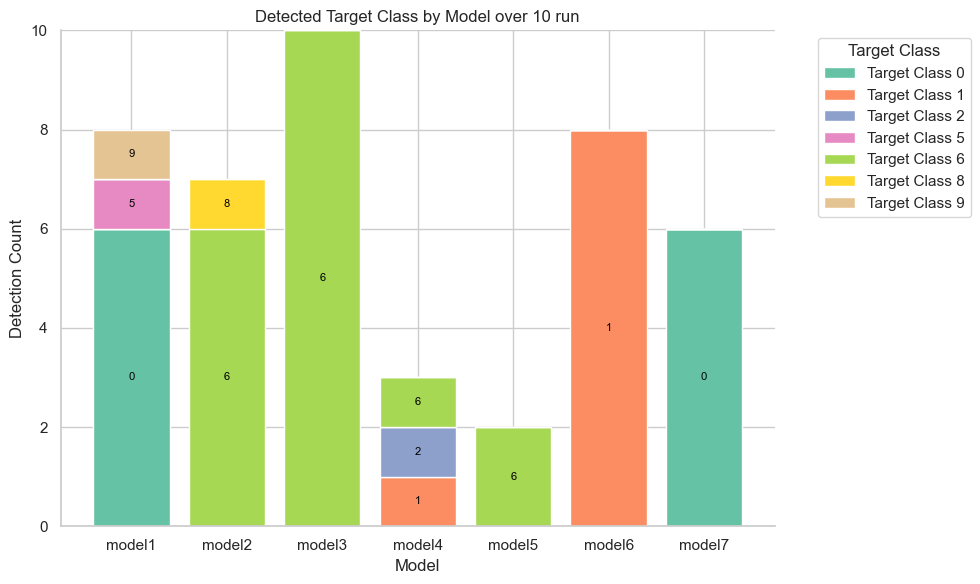

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a simpler color palette
palette = sns.color_palette('Set2')

# Handle NA values by dropping them from the relevant columns
df_merge_dropna = df_merge.dropna(subset=['model', 'target_class'])

# Calculate the target class counts for each model
target_class_counts = df_merge_dropna.pivot_table(index='model', columns='target_class', aggfunc='size', fill_value=0)

# Define colors for each target class
unique_target_classes = sorted(df_merge_dropna['target_class'].unique())
target_class_colors = dict(zip(unique_target_classes, palette[:len(unique_target_classes)]))

# Plot with target class counts stacked, with labels for each section
fig, ax = plt.subplots(figsize=(10, 6))

for target_class in unique_target_classes:
    # Plot each bar segment with the designated color
    ax.bar(
        target_class_counts.index,
        target_class_counts[target_class],
        label=f'Target Class {target_class}',
        bottom=target_class_counts.loc[:, :target_class].sum(axis=1) - target_class_counts[target_class],
        color=target_class_colors[target_class]
    )

    # Add target class labels on each bar segment
    for idx, value in enumerate(target_class_counts[target_class]):
        if value > 0:  # Display label only if the value is non-zero
            ax.text(
                x=idx,
                y=target_class_counts.loc[target_class_counts.index[idx], :target_class].sum() - value / 2,
                s=f'{target_class}',  # Displaying the target class label
                ha='center',
                va='center',
                fontsize=8,
                color="black"
            )

# Titles, labels, and legend setup
ax.set_title('Detected Target Class by Model over 10 run')
ax.set_xlabel('Model')
ax.set_ylabel('Detection Count')
ax.legend(title='Target Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove extra spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


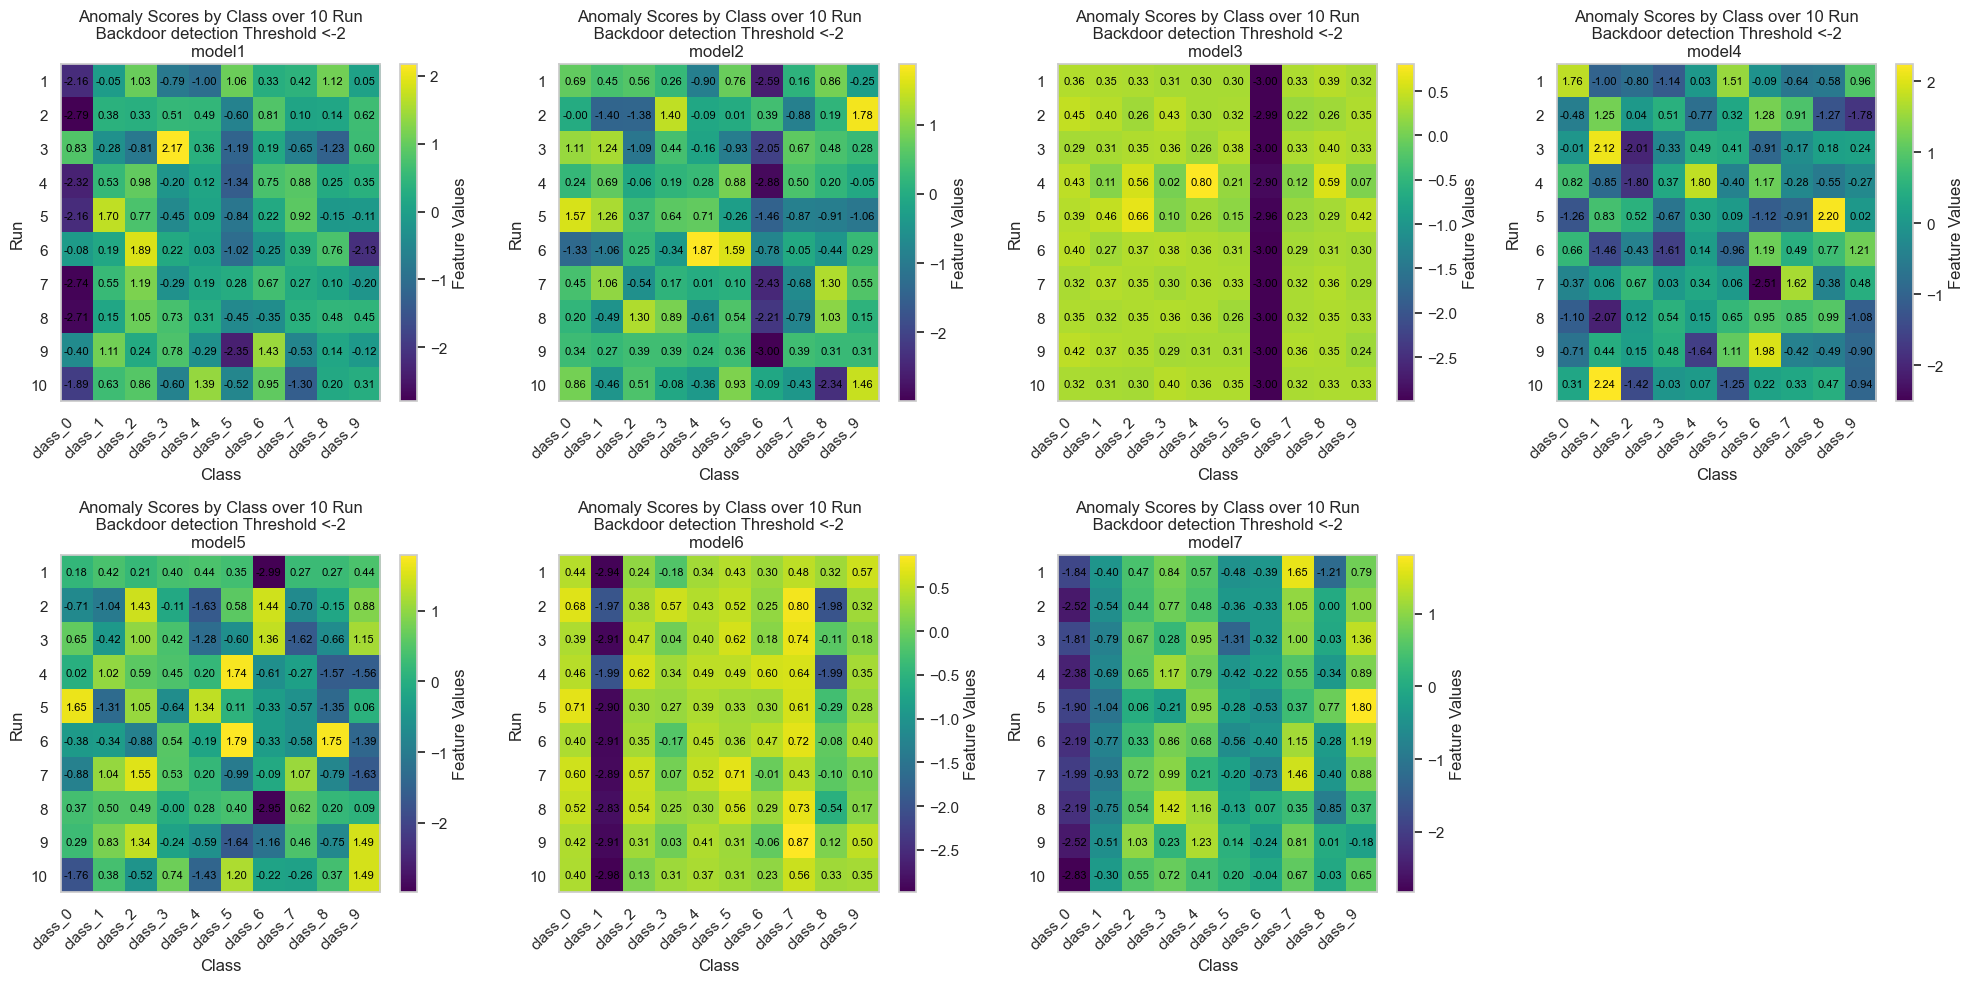

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set a simpler color palette
palette = sns.color_palette('Set2')


# Set models to plot (assuming models_to_plot is defined with the model names of interest)
models_to_plot = df_merge['model'].unique()[:8]  # Limit to 8 models for the 2x4 layout

# Define a colormap for the heatmap
colormap = 'viridis'

# Re-plotting without grid lines
fig, axes = plt.subplots(2, 4, figsize=(20, 10), squeeze=False)
axes = axes.flatten()

# Plotting each model's data in a 2x4 layout without grid lines
for i, model in enumerate(models_to_plot):
    # Filter data for the specific model
    model_data = df_merge[df_merge['model'] == model].set_index('run').iloc[:, :-2]  # Exclude 'target_class' and 'model' columns
    
    # Plotting heatmap for each model
    heatmap = axes[i].imshow(model_data, cmap=colormap, aspect='auto')

    # Add color bar
    cbar = fig.colorbar(heatmap, ax=axes[i])
    cbar.set_label('Feature Values')

    # Annotate each cell with its value
    for row in range(model_data.shape[0]):
        for col in range(model_data.shape[1]):
            value = model_data.iloc[row, col]
            axes[i].text(col, row, f'{value:.2f}', ha='center', va='center', color='black', fontsize=8)

    # Titles and labels for each subplot
    axes[i].set_title(f'Anomaly Scores by Class over 10 Run\n Backdoor detection Threshold <-2 \n{model} ')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Run')

    # Set feature names and run indices
    axes[i].set_xticks(np.arange(model_data.columns.shape[0]))
    axes[i].set_yticks(np.arange(model_data.index.shape[0]))
    axes[i].set_xticklabels(model_data.columns, rotation=45, ha='right')
    axes[i].set_yticklabels(model_data.index)

    # Remove gridlines
    axes[i].grid(False)

# Hide unused subplots if there are fewer than 8 models
for j in range(len(models_to_plot), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
